In [ ]:
library(tidyverse)
library(reshape2)
library(ggsci)
library(readxl)
library(tibble)
library(patchwork)
library(Seurat)
options(Seurat.object.assay.version = "v5")

In [ ]:
# load('/blue/mateescu/lihe.liu/scRNA/intermData/GSE244173/3.1-scPBMC_process.rda')
# sc_pbmc_int2

In [295]:
DATA_DIR = "/blue/mateescu/lihe.liu/scRNA/rawData/"
GSE = "GSE244173"

In [297]:
## merge multiple samples
raw_path = data.frame(
  path = list.files( paste0(DATA_DIR,GSE), full.names = T )
)  %>% 
  setNames( "path" ) %>% 
  mutate( id = gsub( "^.*RAW/", "", path ) )  %>% 
  mutate( id = gsub( "_.*$", "", id ) )  %>% 
  separate( id, c("other", "id"), sep = paste0(GSE,'/') ) %>%
  select( id, path ) %>%
  dplyr::filter(str_detect(path, "Dose"))
raw_path


id        
1  GSM7808275
2  GSM7808276
3  GSM7808277
4  GSM7808278
5  GSM7808279
6  GSM7808280
7  GSM7808281
8  GSM7808282
9  GSM7808283
10 GSM7808284
11 GSM7808285
12 GSM7808286
   path                                                                    
1  /blue/mateescu/lihe.liu/scRNA/rawData/GSE244173/GSM7808275_CG-3Dose-F-3 
2  /blue/mateescu/lihe.liu/scRNA/rawData/GSE244173/GSM7808276_CG-3Dose-Af-3
3  /blue/mateescu/lihe.liu/scRNA/rawData/GSE244173/GSM7808277_CG-3Dose-F-1 
4  /blue/mateescu/lihe.liu/scRNA/rawData/GSE244173/GSM7808278_CG-3Dose-Af-1
5  /blue/mateescu/lihe.liu/scRNA/rawData/GSE244173/GSM7808279_CG-3Dose-F-2 
6  /blue/mateescu/lihe.liu/scRNA/rawData/GSE244173/GSM7808280_CG-3Dose-Af-2
7  /blue/mateescu/lihe.liu/scRNA/rawData/GSE244173/GSM7808281_EG-3Dose-F-1 
8  /blue/mateescu/lihe.liu/scRNA/rawData/GSE244173/GSM7808282_EG-3Dose-Af-1
9  /blue/mateescu/lihe.liu/scRNA/rawData/GSE244173/GSM7808283_EG-3Dose-F-3 
10 /blue/mateescu/lihe.liu/scRNA/rawData/GSE244173/GSM7808284_EG-3Dose-Af-3
11 /blue/mateescu/lihe.liu/scRNA/rawData/GSE244173/GSM7808285_EG-3Dose-F-2 
12 /blue/mateescu/lihe.liu/scRNA/rawData/GSE244173/GSM7808286_EG-3Dose-Af-2

In [ ]:
# read in the data and create a list of Seurat objects
scdata_ls = lapply(c(1:nrow(raw_path)), function(xx){ #nrow(raw_path)
  sample_dir = raw_path[ xx, "path" ]
  sample_id = raw_path[ xx, "id" ]
  # check if sample_dir is a directory not a file
  
  if( file.info( sample_dir )$isdir ){
    expr_temp =  Read10X( sample_dir ) 
    obj = CreateSeuratObject( counts = expr_temp, 
                              # meta.data = metadata, # leave it now
                              project = sample_id, #
                              min.cells = 5, #
                              min.features = 100 #
    )
  }
})

In [ ]:
# merge list to single object
sc_pbmc = merge(scdata_ls[[1]], scdata_ls[2:nrow(raw_path)])
sc_pbmc
#
# save(sc_pbmc, file = paste0(DATA_DIR,GSE,"/","1.2-scPBMC_raw_counts.rda"))
# rm(scdata_ls, raw_path)

Warning message:
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”


An object of class Seurat 
18639 features across 28963 samples within 1 assay 
Active assay: RNA (18639 features, 0 variable features)
 3 layers present: counts.GSM7808275, counts.GSM7808276, counts.GSM7808277

In [301]:
# sc_pbmc@meta.data
# colnames( meta )
table( sc_pbmc$orig.ident )



GSM7808275 GSM7808276 GSM7808277 GSM7808278 GSM7808279 GSM7808280 GSM7808281 
      7583       7374       6499       5311       4872       6992       4783 
GSM7808282 GSM7808283 GSM7808284 GSM7808285 GSM7808286 
      6750       4861       6325       5678       4018 

In [ ]:
# adding meta information
sc_pbmc$individual = meta$`individual:ch1`[ match( sc_pbmc$orig.ident, meta$geo_accession ) ] #
sc_pbmc$vaccine = meta$`treatment:ch1`[ match( sc_pbmc$orig.ident, meta$geo_accession ) ]
sc_pbmc$group = meta$`group:ch1`[ match( sc_pbmc$orig.ident, meta$geo_accession ) ]

table(sc_pbmc$individual)
table(sc_pbmc$vaccine)
table(sc_pbmc$group)



C199E  C71E 
20376  8587 


post-vaccination  pre-vaccination 
           10474            18489 


control group (C) 
            28963 

In [268]:
# check the default ident，when plotting & analysis, will pivot on this
# Idents( sc_pbmc ) # currently different "studies"
Idents( sc_pbmc ) = "orig.ident" # nCount_RNA

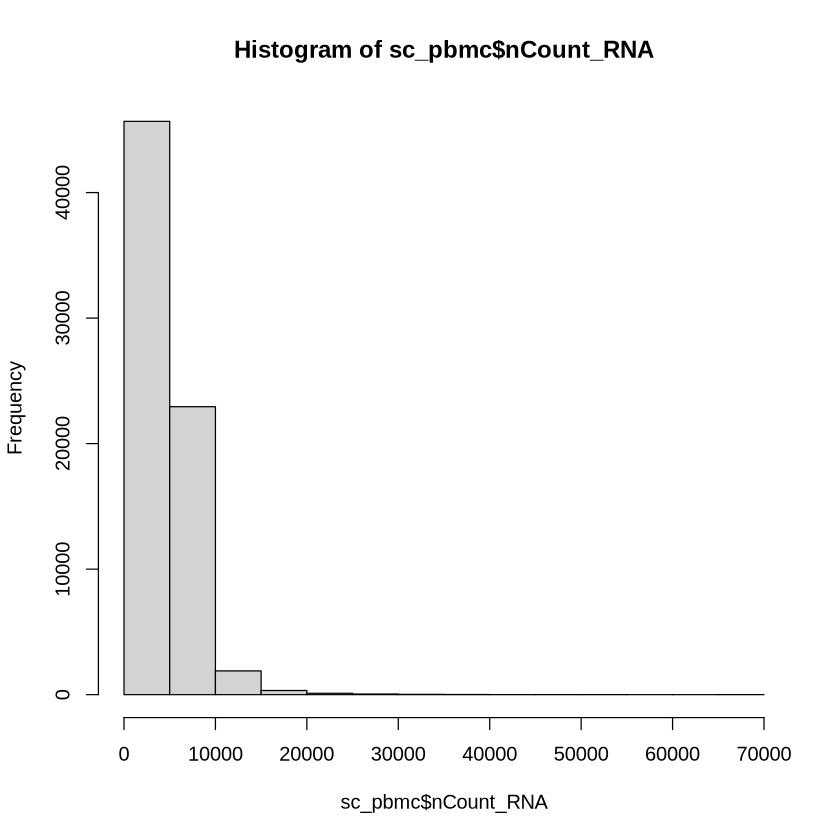

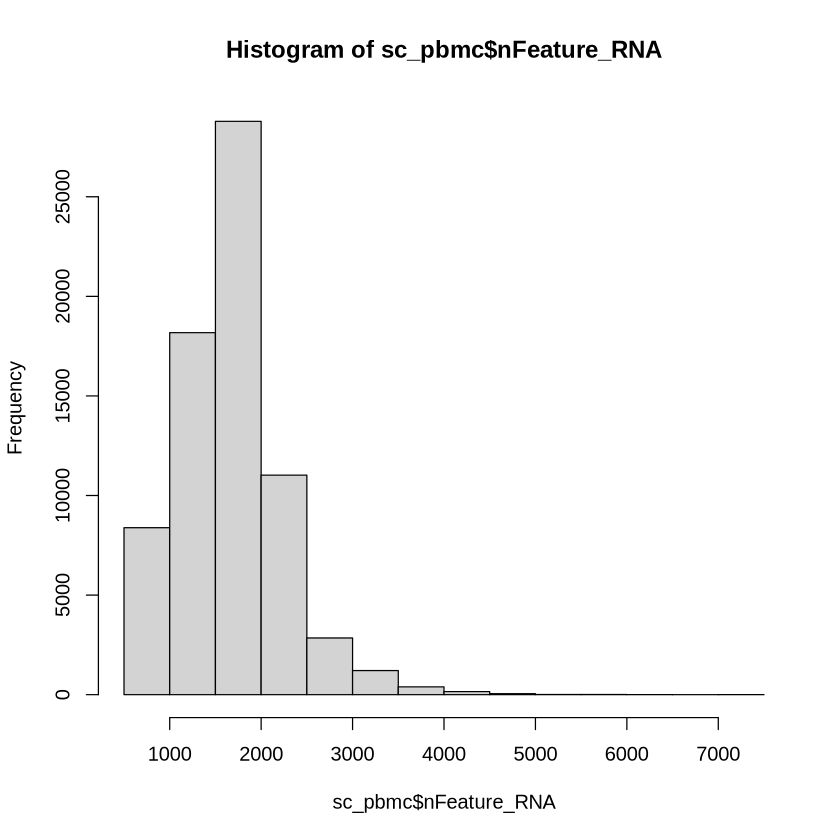

In [302]:
# checking features by plotting
hist( sc_pbmc$nCount_RNA )
hist( sc_pbmc$nFeature_RNA )


In [303]:
# set default assay
DefaultAssay( sc_pbmc )
# DefaultAssay( sc_pbmc ) = "RNA"


[1] "RNA"

In [ ]:
## Initial QC

# a、check（MT）、（ERCC 不同长度和GC含量的细菌RNA序列）、Ribosomal（RPL/S）gene ratio; will add correspoinding properties, like Percent.Mito
sc_pbmc$Percent.Mito = PercentageFeatureSet(sc_pbmc, pattern = "^MT-" ) 
sc_pbmc$Percent.Ercc = PercentageFeatureSet(sc_pbmc, pattern = "^ERCC" ) 
sc_pbmc$Percent.Ribo = PercentageFeatureSet(sc_pbmc, pattern = "^RP[SL]" ) 

# # alternatively, find the features by matching name
# mito.genes <- grep(pattern = "^MT-", 
#                    x = dimnames( sc_pbmc )[[1]], 
#                    value = TRUE)

# percent.mito = PercentageFeatureSet(sc_pbmc, features = mito.genes ) 


# # then use AddMetaData to modify the metadata
# sc_pbmc <- AddMetaData(object = sc_pbmc, 
#                         metadata = percent.mito,
#                         col.name = "percent.MT")

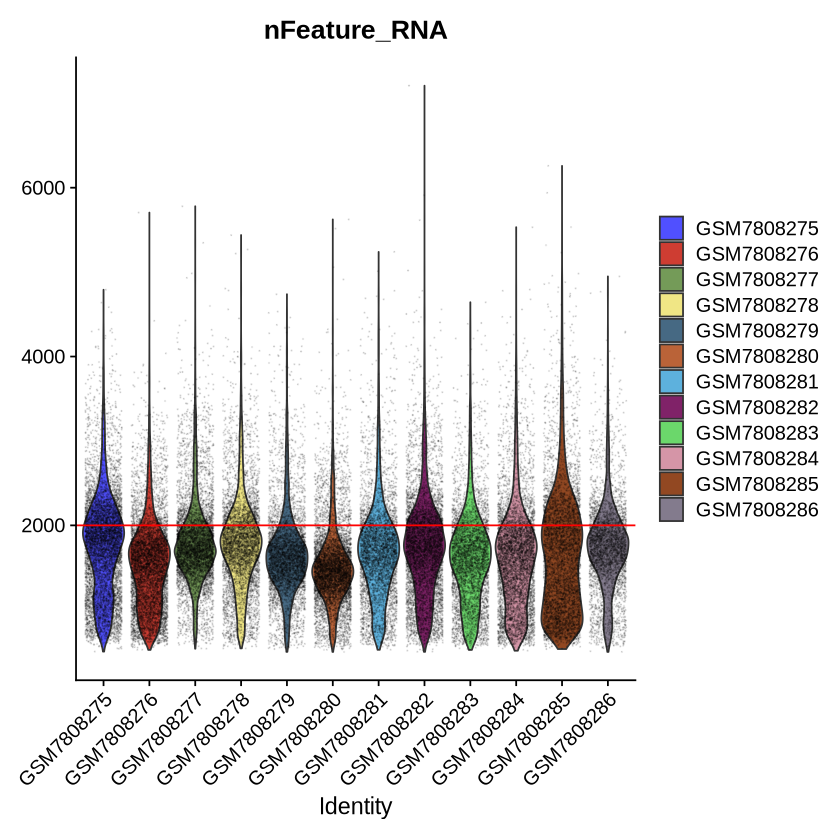

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_hline()`).”


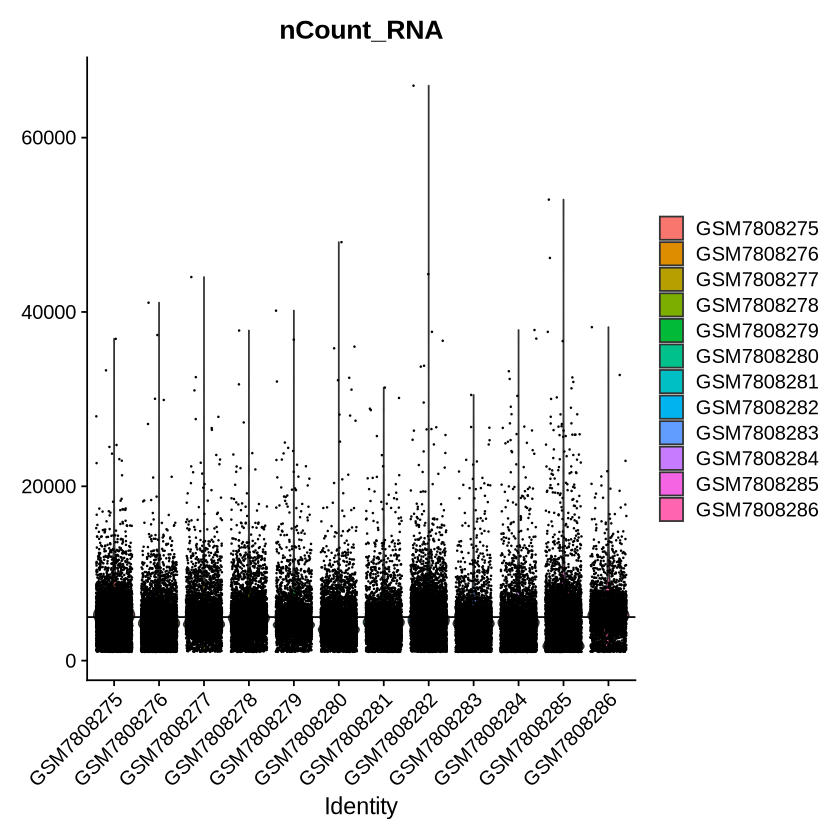

In [304]:

# c、default visualization
VlnPlot(sc_pbmc, features = "nFeature_RNA", group.by = "orig.ident", 
        alpha = 0.1, pt.size = 0.01 ) +
  geom_hline( yintercept = 2000, color = "red" ) +
  scale_fill_igv()
#
VlnPlot(sc_pbmc, features = "nCount_RNA", group.by = "orig.ident" ) +
  geom_hline( yintercept = 5000 )
#  
VlnPlot(sc_pbmc, features = "Percent.Mito", group.by = "orig.ident" ) +
  geom_hline( yintercept = 25, color = "red" )
#
VlnPlot(sc_pbmc, features = "Percent.Ribo", group.by = "orig.ident" )
#
VlnPlot(sc_pbmc, features = "Percent.Mito", group.by = "group" )

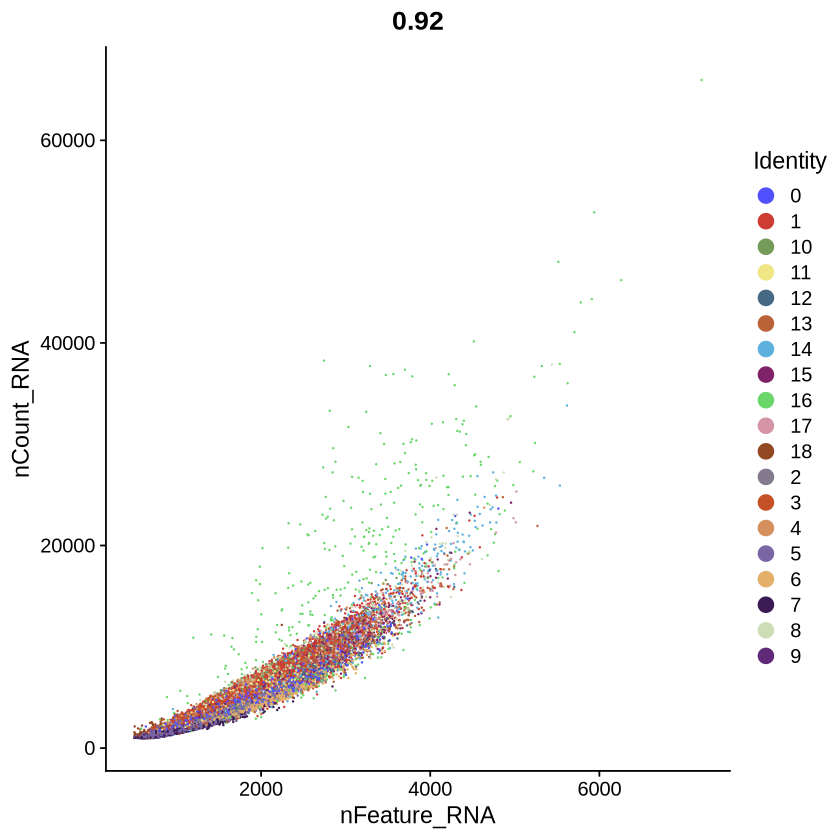

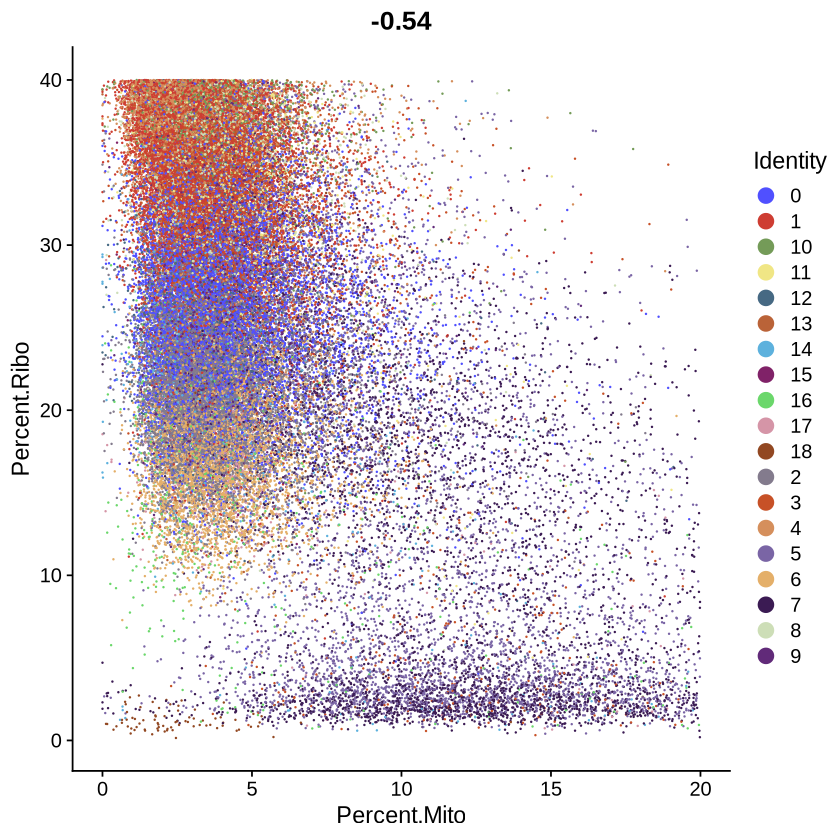

In [305]:
p1 <- FeatureScatter(object = sc_pbmc, raster = F,
                     shuffle = T, pt.size = 0.05,
                     feature1 = "nFeature_RNA", feature2 = "nCount_RNA")+
  scale_color_igv() +
  guides(color = guide_legend(override.aes = list(size = 4))); p1

p2 = FeatureScatter(object = sc_pbmc, raster = F,
                    shuffle = T, pt.size = 0.05,
                    feature1 = "Percent.Mito", feature2 = "Percent.Ribo")+
  scale_color_igv() +
  guides(color = guide_legend(override.aes = list(size = 4))); p2

#
p = p1 + p2 + plot_layout( guides='collect' ) #patchwork
p

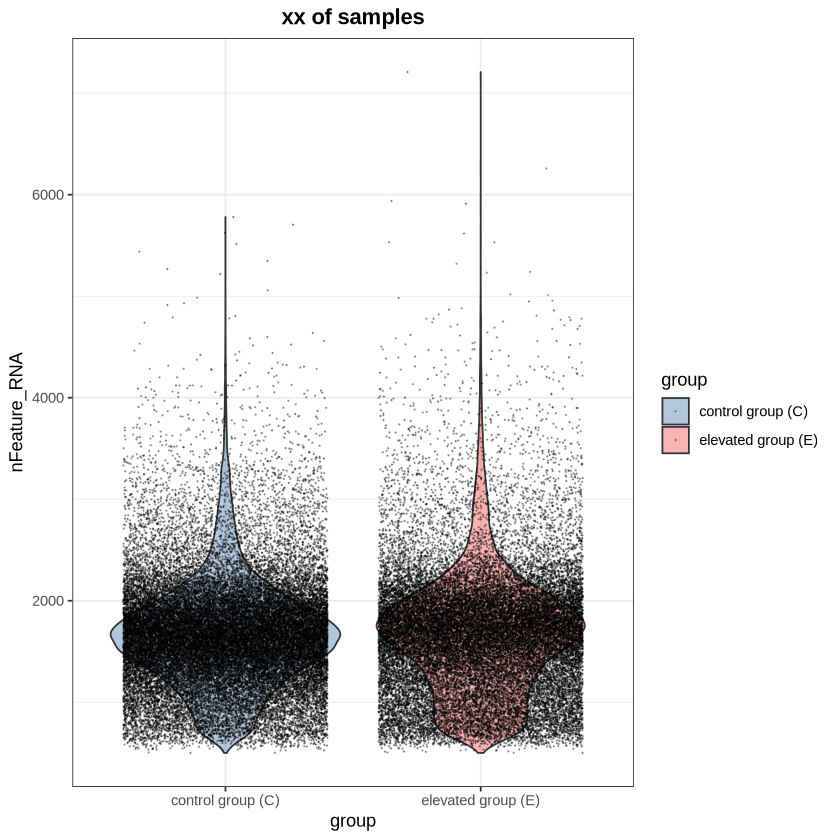

In [306]:
# plot two groups
plotdata = sc_pbmc@meta.data 
#
ggplot( plotdata, aes( x = group, y = nFeature_RNA, fill = group ) )+
  geom_violin( position = "identity", alpha = 0.3 ) +
  geom_jitter( size = 0.05, alpha = 0.3 )+
  ggtitle( "xx of samples"  )+
  theme_bw()+
  theme(
    plot.title = element_text( face = "bold", hjust = 0.5),
    plot.background = element_rect(fill = "transparent",colour = NA)
  )+
  scale_fill_lancet() # ggsci


In [204]:
# ##  QC: check for different gene types and potentially filter (personal prefereneces)
# hist( sc_pbmc$nCount_RNA, breaks = 100 )
# hist( sc_pbmc$nFeature_RNA, breaks = 100 )
# hist( sc_pbmc$Percent.Mito, breaks = 100 )
# hist( sc_pbmc$Percent.Ribo, breaks = 100 )

# quantile( sc_pbmc$nCount_RNA )
# quantile( sc_pbmc$Percent.Mito )

# table(sc_pbmc$nCount_RNA > 1000 ) 
# table(sc_pbmc$nFeature_RNA > 500 )
# table(sc_pbmc$nFeature_RNA < 5000 ) 
# table( sc_pbmc$Percent.Mito < 20 ) 
# table( sc_pbmc$Percent.Ercc < 5 )
# table( sc_pbmc$Percent.Ribo < 40 )


In [205]:
# personal perferences
sc_pbmc = subset( sc_pbmc, nCount_RNA > 1000 ) # 
sc_pbmc = subset( sc_pbmc, nFeature_RNA > 500 )  #
sc_pbmc = subset( sc_pbmc, Percent.Mito < 20 )  # 
sc_pbmc = subset( sc_pbmc, Percent.Ribo < 40 )  #

In [ ]:
## DoubletFinder for removing doublets (multiple celss captured in one droplet)
## use DoubletFinder to remove doublets
## DoubletFinder manuually combine different cell to see if there are cells look alike then potentially remove them

# And cell cycle scoring is also a good idea, but optional
# find cell cycle genes and infer score
# G1/S
# S
# G2/M
# M

In [208]:
## normalization and scaling
library( future )
availableCores()
nbrOfWorkers()

# plan("multisession", workers = 16 ) 
# plan()


cgroups.cpuset 
            16

[1] 16

In [215]:
gc()
options(future.globals.maxSize = 4000 * 1024^2)  # Set to 3 GiB

used      (Mb)   gc trigger (Mb)   max used   (Mb)  
Ncells   4409764  235.6    7060055  377.1    7060055  377.1
Vcells 476918143 3638.6 1304079395 9949.4 1208868263 9223.0

In [ ]:
# a、
sc_pbmc = NormalizeData(sc_pbmc,
                         normalization.method = "LogNormalize", 
                         block.size = 1000 #
                         ) 
# b、find high variable genes
sc_pbmc = FindVariableFeatures(sc_pbmc ) # default 2000


Normalizing layer: counts.GSM7808275



In [ ]:
# c、scaling
sc_pbmc <- ScaleData(sc_pbmc, 
                     # features = NULL, # default 2000
                     # vars.to.regress = NULL, # the features to regress out
                     block.size = 1000 #
                     ) 
#


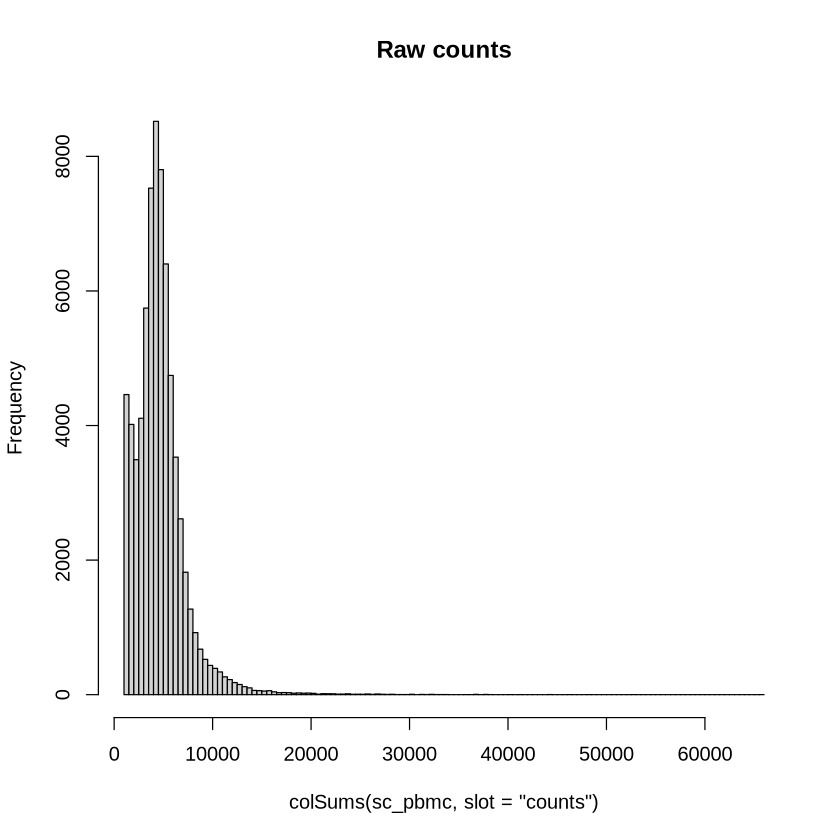

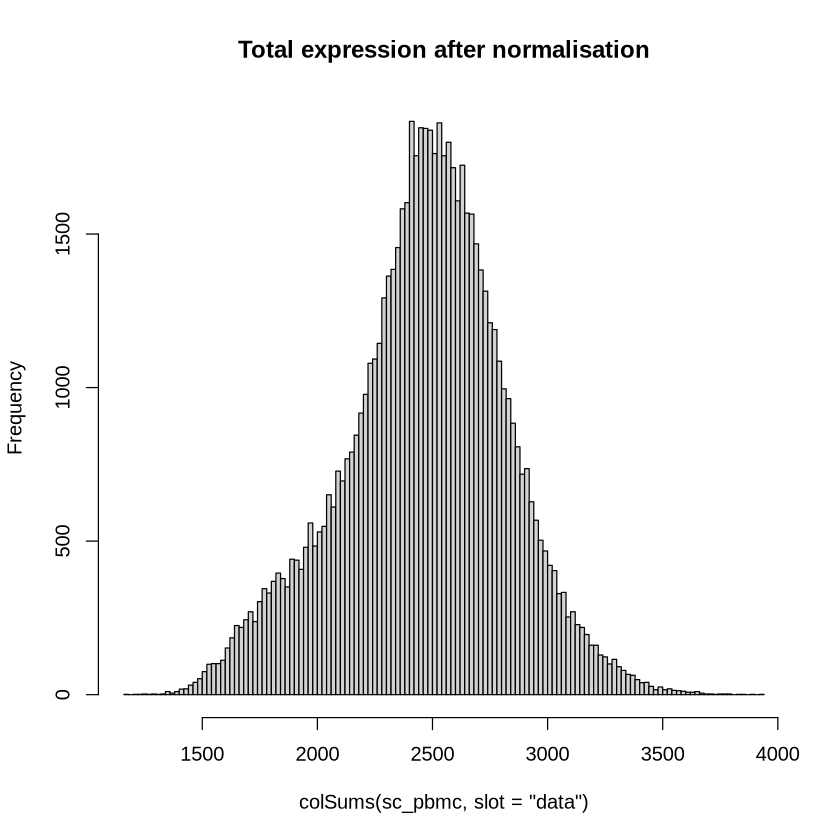

In [309]:
# check the distribution of the data
hist(colSums(sc_pbmc, slot = "counts" ),
     breaks = 100,
     main = "Raw counts" )

hist(colSums(sc_pbmc, slot = "data" ),
     breaks = 100,
     main = "Total expression after normalisation" ) 

hist(colSums(sc_pbmc, slot = "scale.data" ),
     breaks = 100,
     main = "Total expression after scaled" )



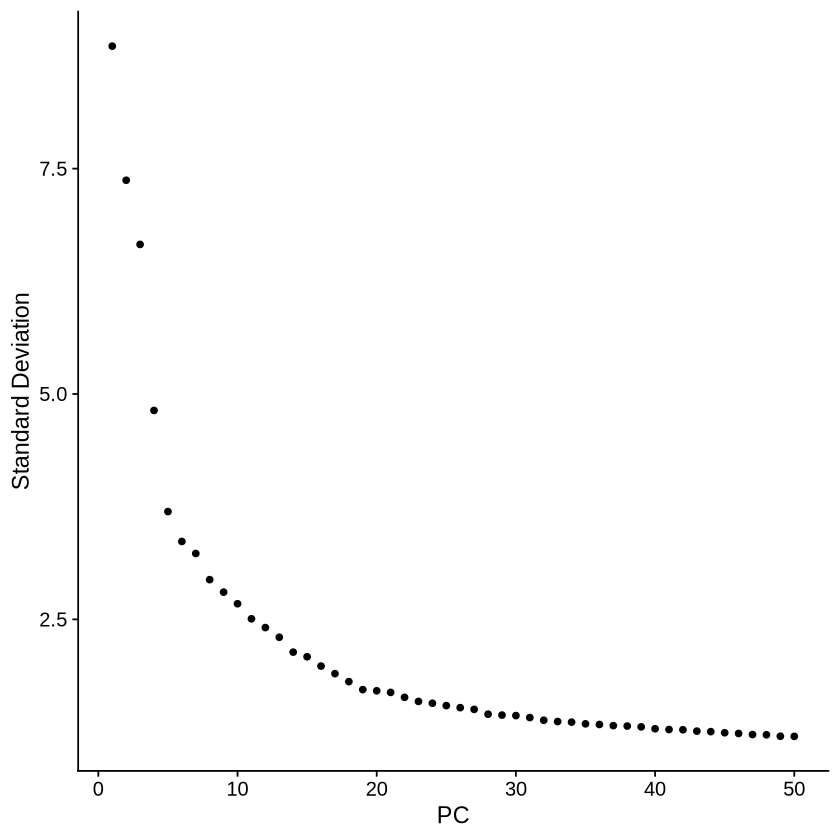

In [ ]:
## 1.7、dim reduce and clustering----

sc_pbmc <- RunPCA(sc_pbmc,
                  npcs = 50,
                  seed.use = 42 )

ElbowPlot(sc_pbmc, ndims = 50 )  

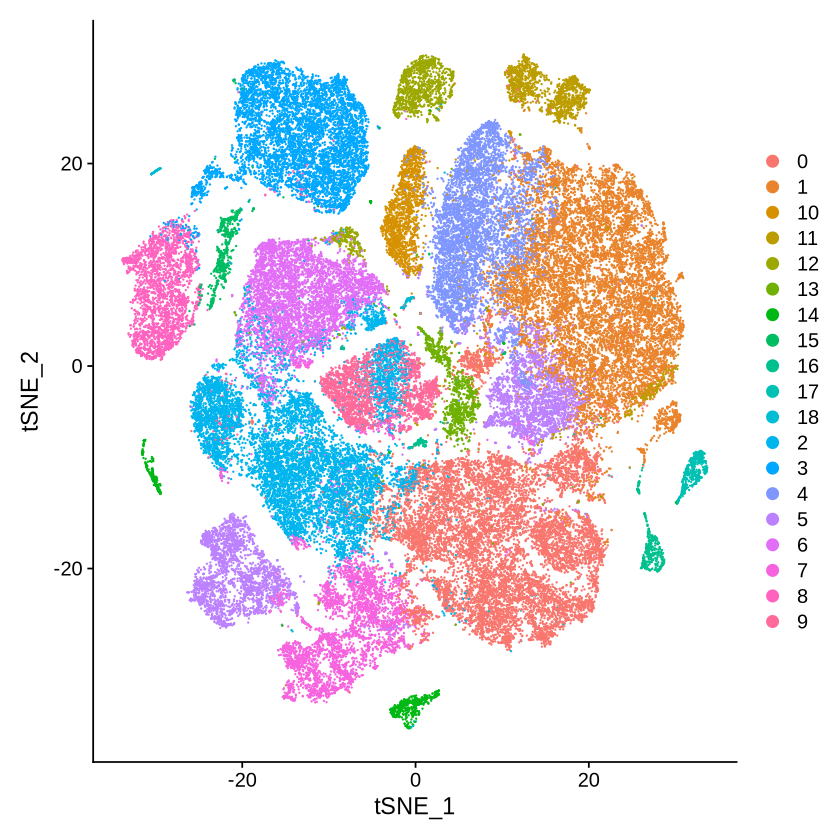

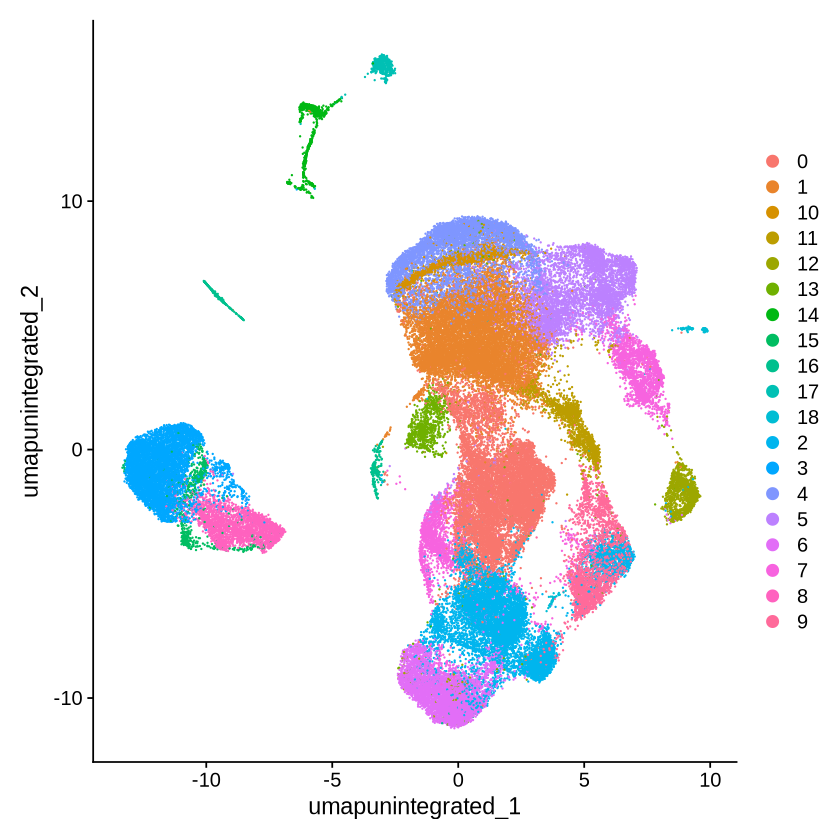

In [ ]:
# b、can also use tsne and umap
sc_pbmc <- RunTSNE(sc_pbmc, dims = 1:20, reduction = "pca", reduction.name = "tsne.unintegrated") 
sc_pbmc <- RunUMAP(sc_pbmc, dims = 1:20, reduction = "pca", reduction.name = "umap.unintegrated")

DimPlot( sc_pbmc, reduction = "tsne.unintegrated" )
DimPlot( sc_pbmc, reduction = "umap.unintegrated" )


In [ ]:
# 
sc_pbmc <- FindNeighbors(sc_pbmc, dims = 1:20, reduction = "pca" )
sc_pbmc <- FindClusters(sc_pbmc, 
                        resolution = 1, # can adjust for different resolution/view
                        cluster.name = "unintegrated_clusters")


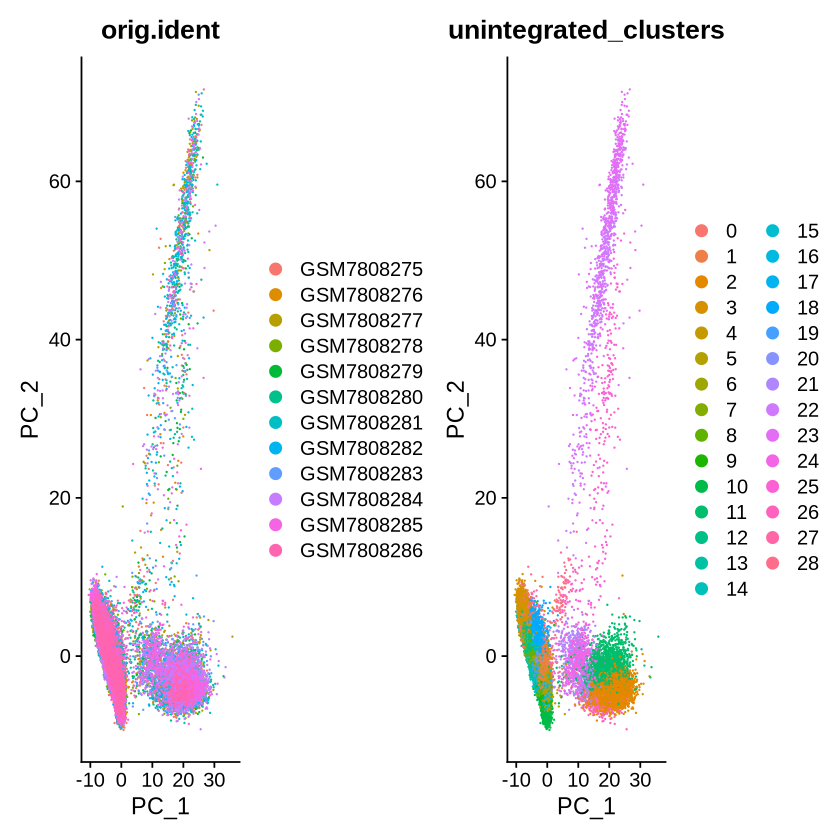

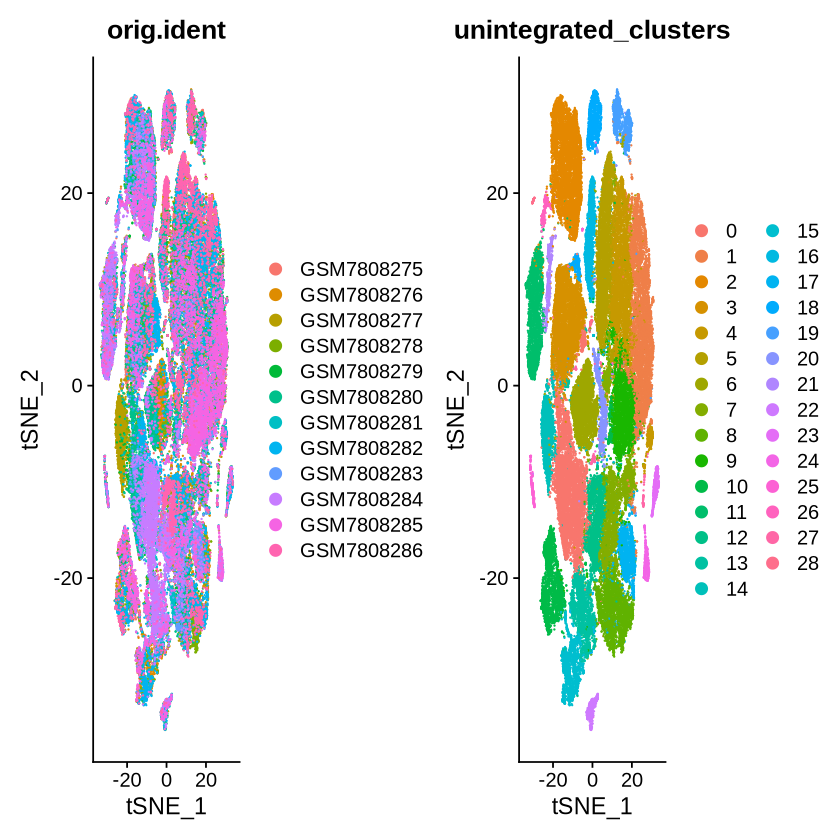

In [313]:
DimPlot(sc_pbmc, reduction = "pca", group.by = c("orig.ident", "unintegrated_clusters" ))
DimPlot(sc_pbmc, reduction = "tsne.unintegrated", group.by = c("orig.ident", "unintegrated_clusters" ))
DimPlot(sc_pbmc, reduction = "umap.unintegrated", group.by = c("orig.ident", "unintegrated_clusters" ))

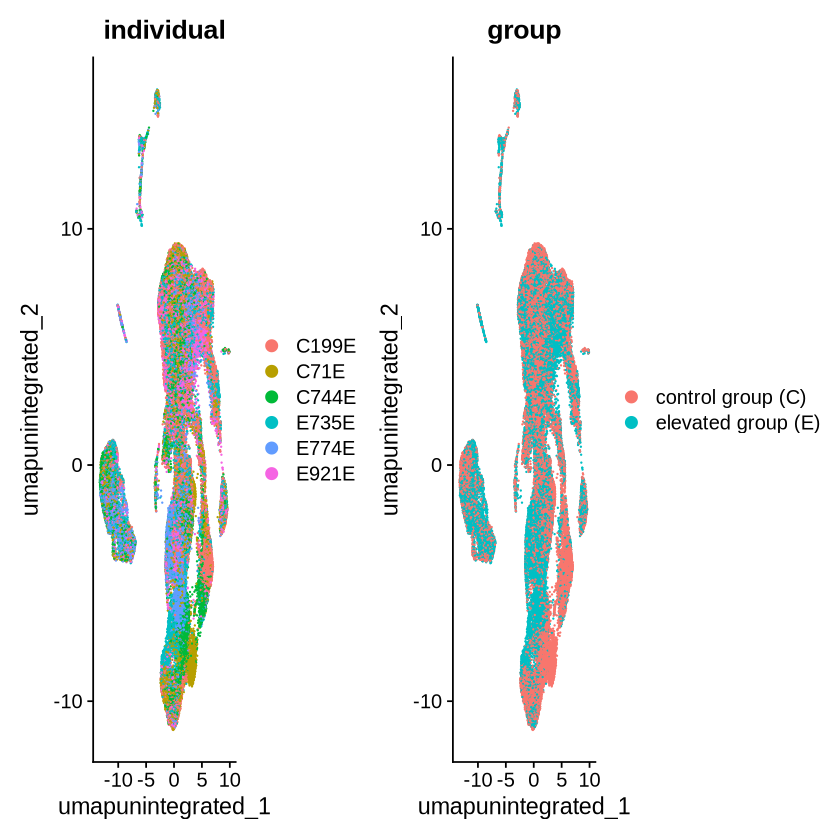

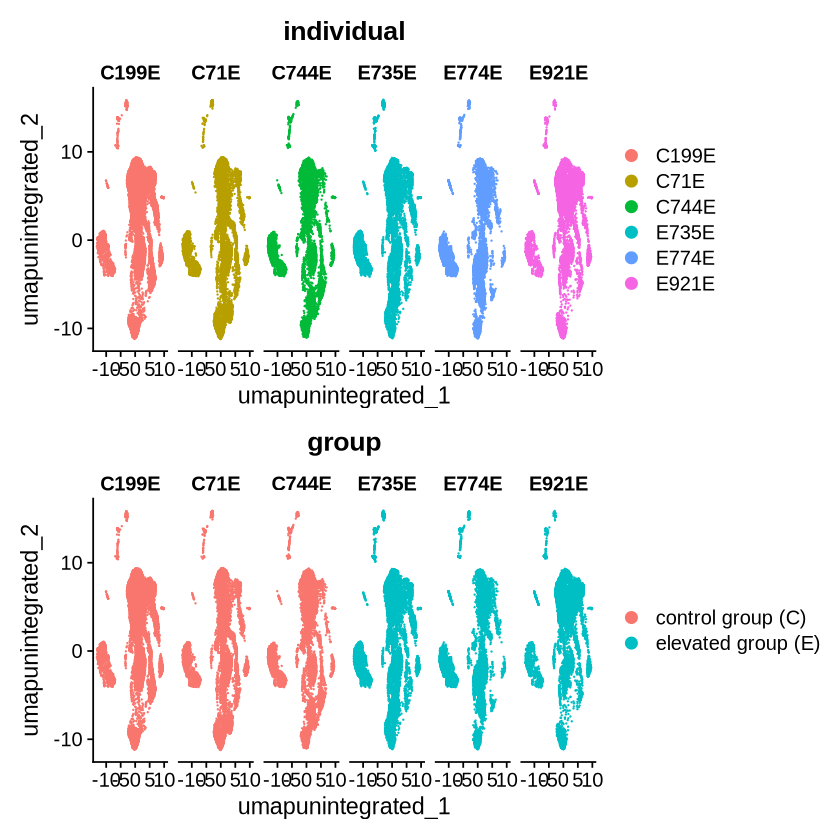

In [ ]:
# among groups to check for batch effect
DimPlot(sc_pbmc, reduction = "umap.unintegrated", group.by = c("individual", "group" ), shuffle = T ) # shuffle = T is important to avoid one layer cover another

# 
DimPlot(sc_pbmc, reduction = "umap.unintegrated", group.by = c("individual", "group" ), split.by = "individual" ) 


In [ ]:
### integration of different samples
#### there is no standard way to integrate different samples, but we can try different methods
# IntegrateLayers has differnent approaches：CCAIntegration，HarmonyIntegration，JointPCAIntegration，RPCAIntegration

In [ ]:
sc_pbmc_int = sc_pbmc

# a、approach1: CCA
sc_pbmc_int <- IntegrateLayers(
  object = sc_pbmc_int, 
  method = CCAIntegration,
  orig.reduction = "pca", 
  new.reduction = "integrated.cca",
  verbose = TRUE )

#
sc_pbmc_int <- FindNeighbors(sc_pbmc_int, reduction = "integrated.cca", dims = 1:20)
sc_pbmc_int <- FindClusters(sc_pbmc_int, resolution = 1, cluster.name = "cca_clusters")
sc_pbmc_int <- RunUMAP(sc_pbmc_int, reduction = "integrated.cca", dims = 1:20, reduction.name = "umap.cca")


# b、approch2: Harmony
sc_pbmc_int <- IntegrateLayers(
  object = sc_pbmc_int, 
  method = HarmonyIntegration,
  orig.reduction = "pca", 
  new.reduction = "harmony",
  verbose = TRUE )

# 
sc_pbmc_int <- FindNeighbors(sc_pbmc_int, reduction = "harmony", dims = 1:20)
sc_pbmc_int <- FindClusters(sc_pbmc_int, resolution = 1, cluster.name = "harmony_clusters")
sc_pbmc_int <- RunUMAP(sc_pbmc_int, reduction = "harmony", dims = 1:20, reduction.name = "umap.harmony")


# c、others：RPCA、JointPCA


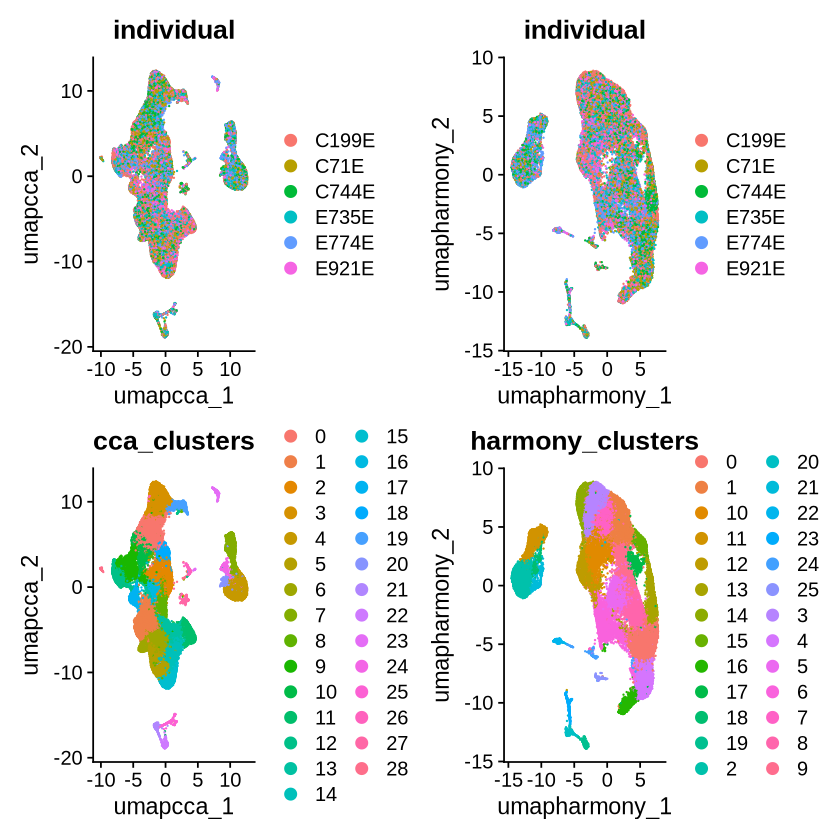

In [315]:
# clustering results
p1 <- DimPlot(sc_pbmc,reduction = "umap.cca", 
              group.by = c("individual", "cca_clusters"),
              combine = FALSE,label.size = 2, shuffle = T )
#
p2 <- DimPlot(sc_pbmc,reduction = "umap.harmony", 
              group.by = c("individual", "harmony_clusters"),
              combine = FALSE,label.size = 2, shuffle = T)
#
wrap_plots(c(p1, p2), ncol = 2, byrow = F)

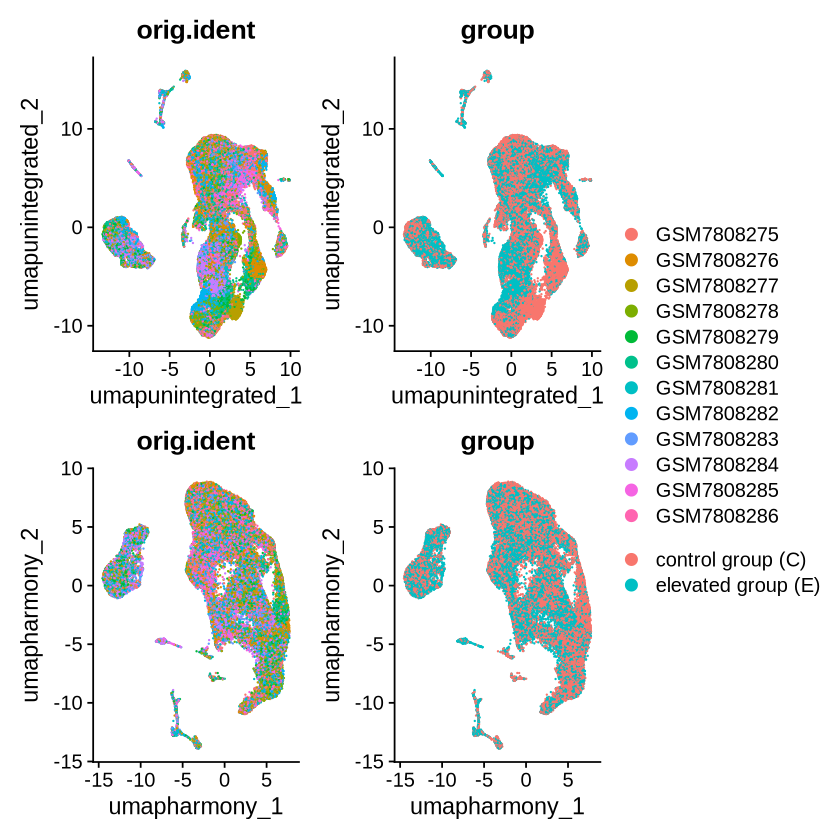

In [317]:
# e、batch effect removal
p1 = DimPlot( sc_pbmc, reduction = "umap.unintegrated", shuffle = T,
              group.by = c("orig.ident", "group"),combine = FALSE )
#
p2 = DimPlot( sc_pbmc, reduction = "umap.harmony", shuffle = T,
              group.by = c("orig.ident", "group"),combine = FALSE )
#
wrap_plots( c(p1, p2), ncol = 2, byrow = T, guides = "collect" )


In [ ]:
# f、in this analysis, use harmony as the integration method
sc_pbmc <- RunTSNE(sc_pbmc_int, dims = 1:20, reduction = "harmony" )
sc_pbmc <- RunUMAP(sc_pbmc_int, dims = 1:20, reduction = "harmony" )

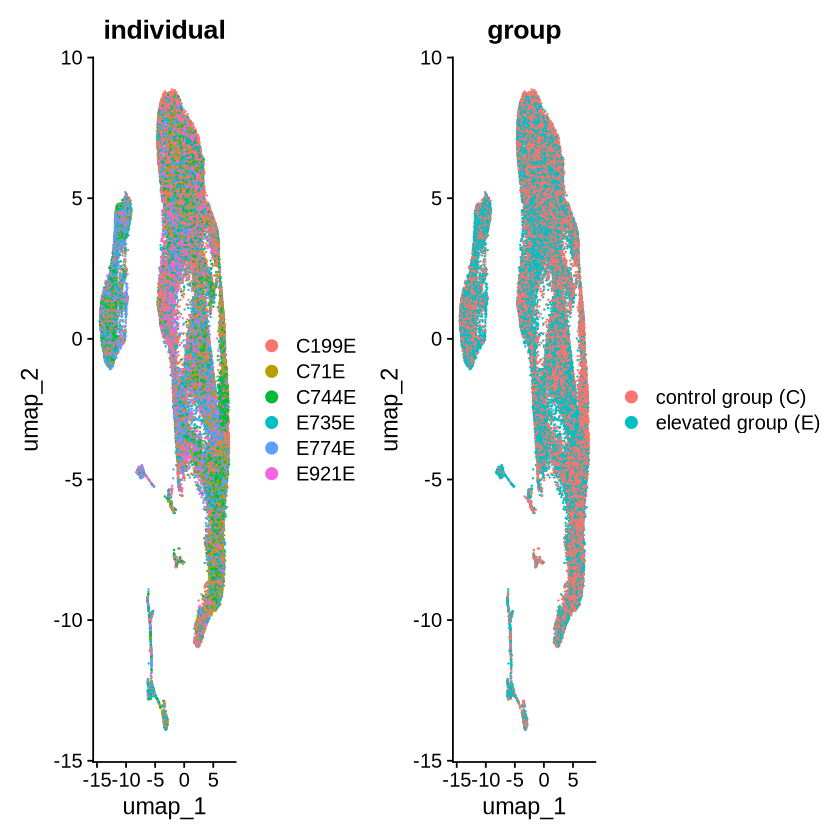

In [ ]:
## 3.1 
# need to use JoinLayers to join layers
# after joining layers there is only one counts & data
sc_pbmc <- JoinLayers( sc_pbmc )
#
sc_pbmc <- FindNeighbors(sc_pbmc, reduction = "harmony", dims = 1:20)
#
DimPlot( sc_pbmc, reduction = "umap", shuffle = T,
         group.by = c("individual", "group"), combine = T )




In [ ]:

library(clustree)

sc_pbmc <- FindClusters(
  object = sc_pbmc,
  resolution = c( seq( 0.1, 1.0, 0.1) ) # 分辨率从 0.2-1.6，间隔 0.2 一档
)

# clustree(sc_pbmc@meta.data, prefix = "RNA_snn_res.")
# ggsave( filename = "3.1-clustree.pdf", width = 12, height = 9 )


In [321]:
# check clustering results

p1 = DimPlot( sc_pbmc_int2, reduction = "umap", group.by = "RNA_snn_res.0.1", 
         label = T, repel = F, shuffle = T )
#
p2 = DimPlot( sc_pbmc_int2, reduction = "umap", group.by = "RNA_snn_res.0.2", 
         label = T, repel = F, shuffle = T )
#
p3 = DimPlot( sc_pbmc_int2, reduction = "umap", group.by = "RNA_snn_res.0.3", 
         label = T, repel = F, shuffle = T )
#
p4 = DimPlot( sc_pbmc_int2, reduction = "umap", group.by = "RNA_snn_res.0.4", 
              label = T, repel = F, shuffle = T )
#
p5 = DimPlot( sc_pbmc_int2, reduction = "umap", group.by = "RNA_snn_res.0.6", 
              label = T, repel = F, shuffle = T )
#
p6 = DimPlot( sc_pbmc_int2, reduction = "umap", group.by = "RNA_snn_res.1", 
              label = T, repel = F, shuffle = T )

#
p = p1 + p2 + p3 + p4 + p5 + p6 + plot_layout( ncol = 3 )



    0     1    10    11    12    13    14    15    16    17    18     2     3 
11043 10959  1758  1549  1425  1130   829   706   638   500   195  9431  6090 
    4     5     6     7     8     9 
 5486  5241  5017  3902  2676  2471 

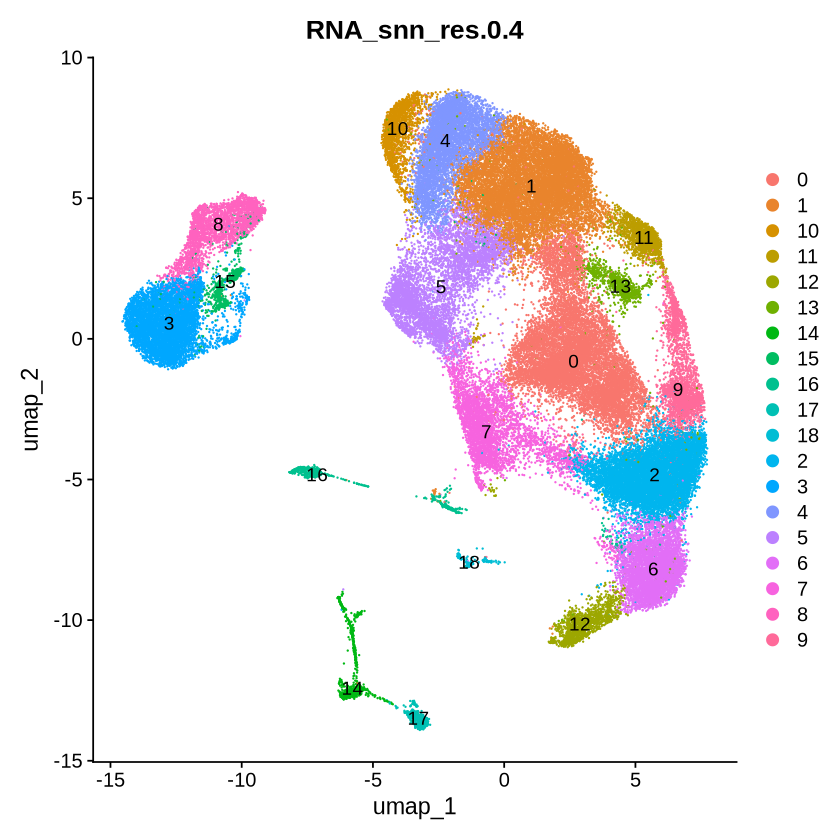

In [322]:
# use resolution 0.4
p4
table(sc_pbmc$seurat_clusters)

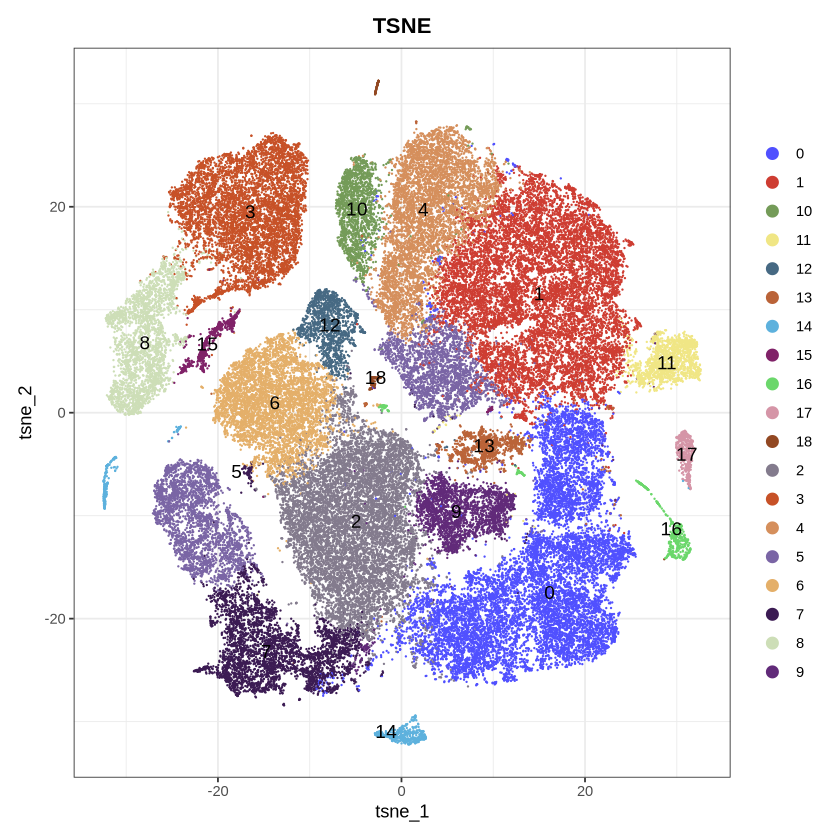

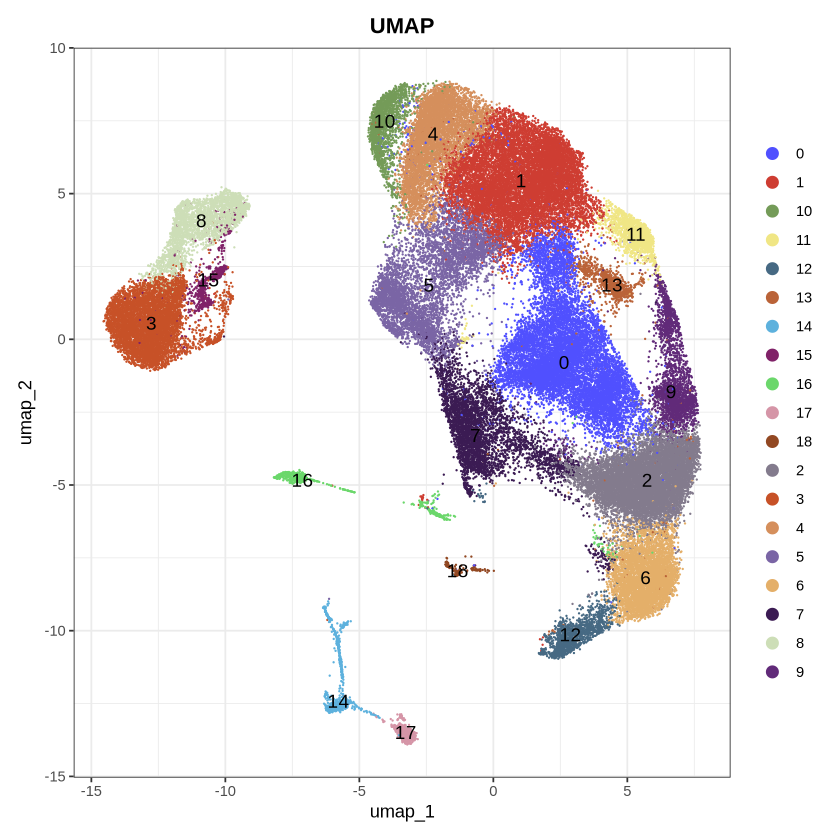

In [ ]:
#
p1 = TSNEPlot( sc_pbmc_int2,
               label =T, repel = F,
                 group.by = 'seurat_clusters')+
  ggtitle("TSNE")+
  theme_bw( )+
  theme(
    plot.title = element_text( face = "bold", hjust = 0.5),
    plot.background = element_rect(fill = "transparent",colour = NA)
  ) +
  scale_color_igv(); p1
#
p2 = UMAPPlot( sc_pbmc_int2,
               label =T,
               group.by = 'seurat_clusters')+
  ggtitle("UMAP")+
  theme_bw( )+
  theme(
    plot.title = element_text( face = "bold", hjust = 0.5),
    plot.background = element_rect(fill = "transparent",colour = NA)
  ) +
  scale_color_igv(); p2
#
p1 + p2 + plot_layout( guides='collect' )


In [ ]:
## 3.2 Marker genes of each cluster
Idents( sc_pbmc_int2 ) = "seurat_clusters"
#
sc.markers <- FindAllMarkers(object = sc_pbmc_int2, 
                             only.pos = FALSE, # 是否只保留表达相对上调的基因，设置FALSE则会保留下调的
                             test.use = "wilcox", # 默认使用 wilcox 非参数检验，其它选项可以查看说明
                             slot = "data", # 需要注意的是，默认使用 data，而不是 counts
                             min.pct = 0.25, # 设置表达比例的阈值，没有统一标准，差异基因很多的情况下可以把阈值调高，差异基因有1000个够用
                             logfc.threshold = 0.25 # 设置 log2FC 即差异倍率的阈值，没有统一标准，差异基因很多的情况下可以把阈值调高
                             )


In [331]:
# visualiziaion of marker genes
top5 = sc.markers %>%
  filter( avg_log2FC > 0 ) %>%
  group_by(cluster) %>%
  filter( p_val_adj < 0.05 ) %>%
  top_n( 3, avg_log2FC ) %>%
  group_by()

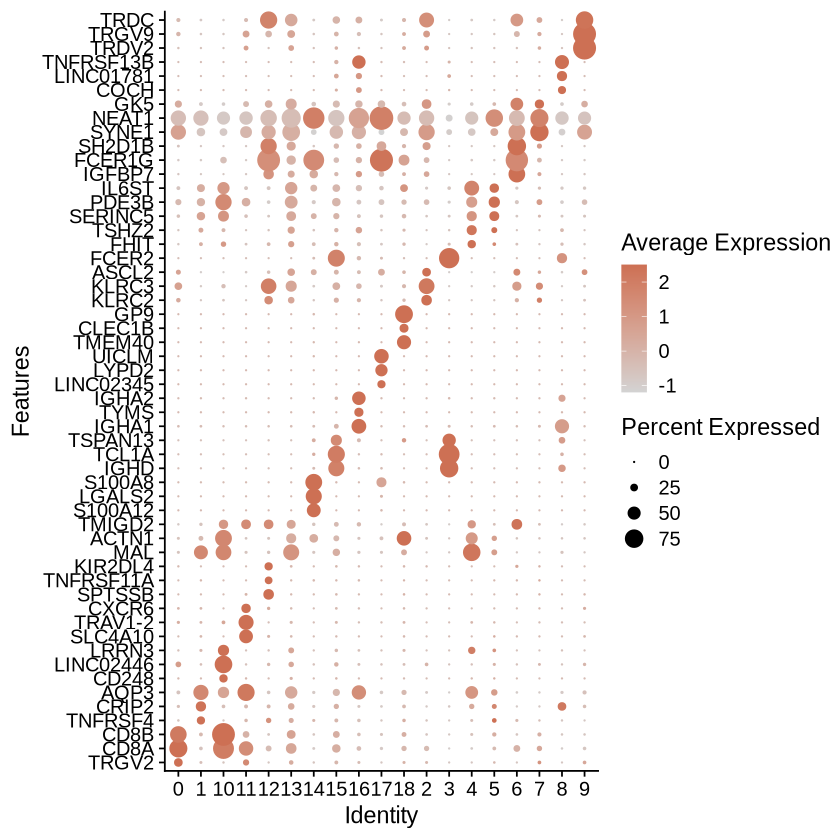

In [333]:
# DoHeatmap(object = sc_pbmc, 
#           features = top5$gene, 
#           label = TRUE) +
#   scale_fill_gradient( low = "grey", high = "salmon" )


DotPlot( object = sc_pbmc, 
         group.by = "seurat_clusters",
         cols = c("lightgrey", "salmon3"),
         features = unique( top5$gene ) ) +
  coord_flip()

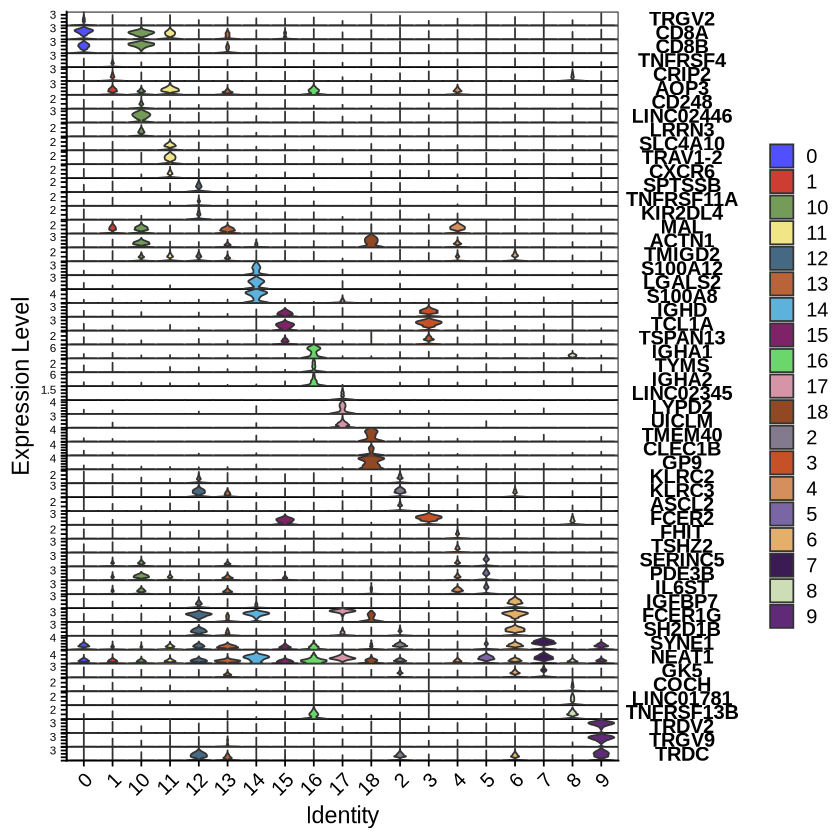

In [334]:
VlnPlot( object = sc_pbmc_int2,
         group.by = "seurat_clusters", fill.by = "ident",
         stack = T, flip = T,
         features = unique( top5$gene ) ) +
  scale_fill_igv()


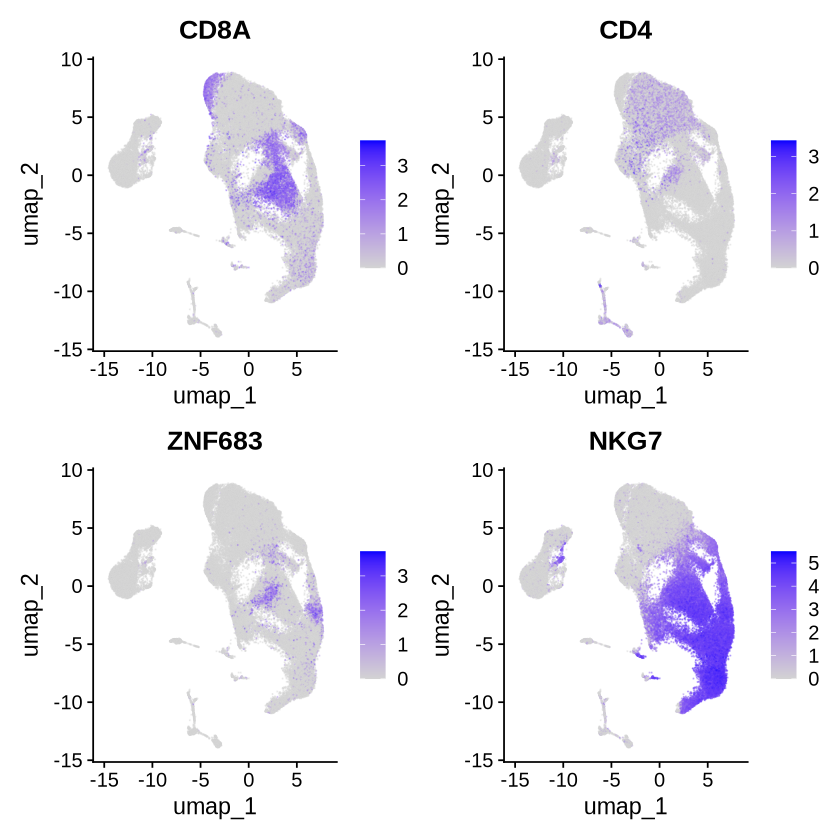

In [335]:
FeaturePlot( sc_pbmc, features = c( "CD8A", "CD4", "ZNF683", "NKG7" ), order = F, alpha = 0.3, reduction = "umap" )

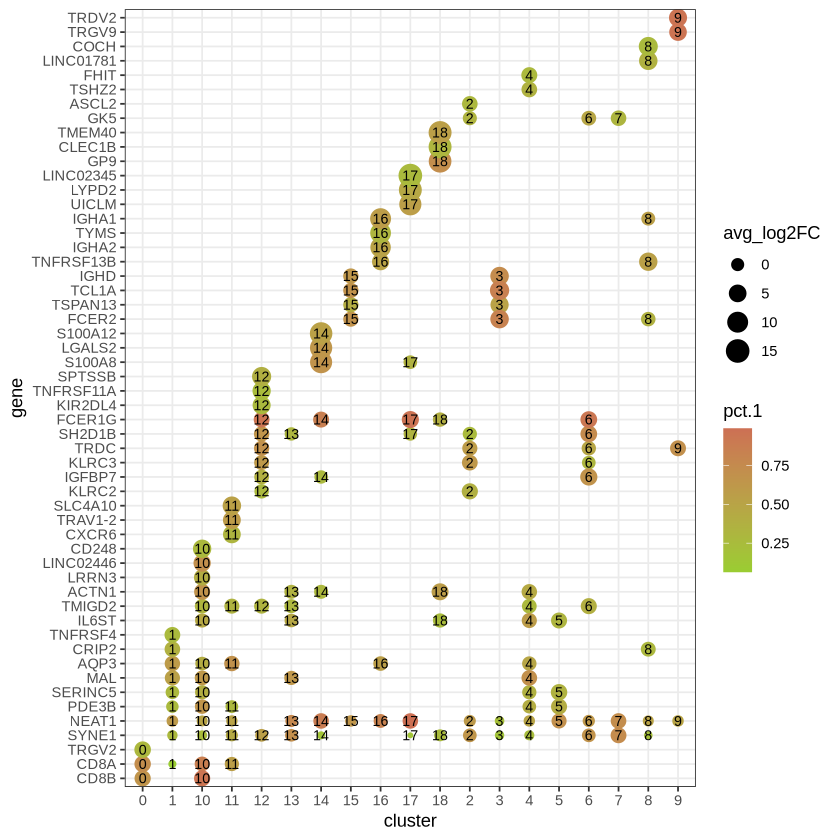

In [337]:
plotdt = sc.markers %>% 
  filter( gene %in% top5$gene ) %>%
  arrange( cluster, avg_log2FC ) %>% 
  mutate( gene = factor( gene, levels = unique(gene), ordered = T ) ) #
#
ggplot( plotdt, aes( x = cluster, 
                     y = gene, 
                     # y = as.character(gene), 
                     size = avg_log2FC, 
                     color = pct.1 ) ) +
  geom_point(  )+
  geom_text( aes( label = cluster ), size = 3, color = "black" ) +
  theme_bw( )+
  theme(
    plot.title = element_text( face = "bold", hjust = 0.5),
    plot.background = element_rect(fill = "transparent",colour = NA)
  ) +
  scale_color_gradient( low = "olivedrab3", high = "salmon3" )



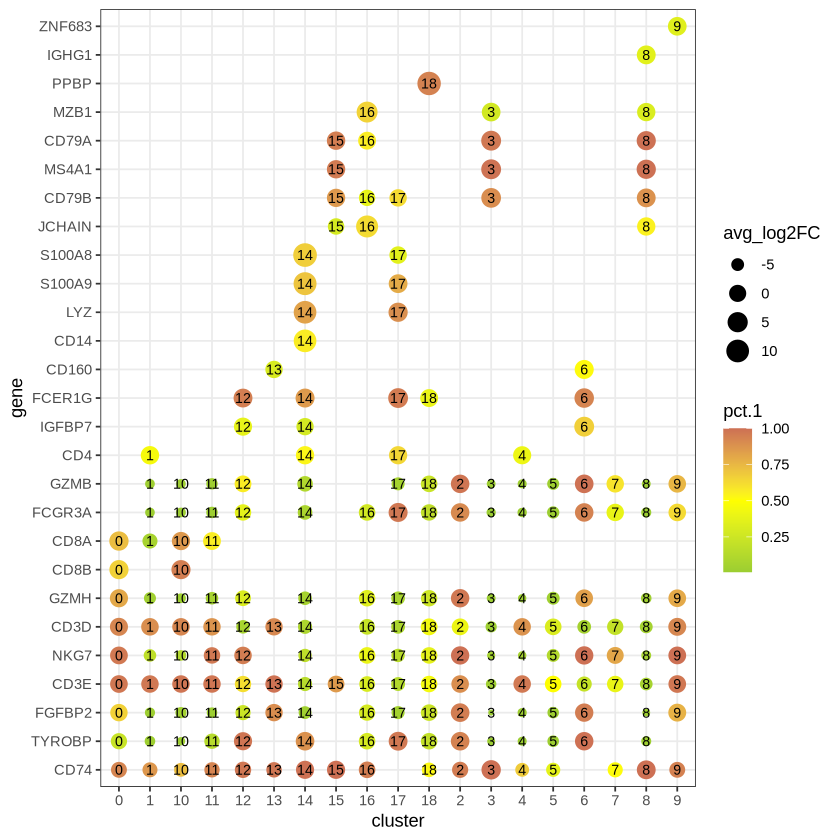

In [338]:
## 3.3 cell cluster annotation
# could be useful：https://www.rndsystems.com/cn/resources/cell-markers
# cell clusters were annotated into 8 cell types in this study
# CD8+ T cells (CD8A and CD8B), 其他：CD3D, CD3E
# CD4+ T cells (CD4), 
# natural killer (NK) T cells (CD8A, CD8B, and ZNF683), 
# NK cells (NKG7, FCER1G, FGFBP2, FCGR3A, GZMH, TYROBP, and IGFBP7), 其他：CD160, GZMB
# B cells (CD74, CD79A, CD79B, and MS4A1), 
# plasma cells (JCHAIN, MZB1, and IGHG1), 
# monocytes (LYZ, S100A8, S100A9, and CD14), 
# platelets (PPBP)

marker_author = c( "CD8A", "CD8B", "CD3D", "CD3E",
                   "CD4", 
                   "ZNF683", 
                   "NKG7", "FCER1G", "FGFBP2", "FCGR3A", "GZMH", "TYROBP", "IGFBP7", "CD160", "GZMB",
                   "CD74", "CD79A", "CD79B", "MS4A1",
                   "JCHAIN", "MZB1", "IGHG1", 
                   "LYZ", "S100A8", "S100A9", "CD14", 
                   "PPBP" )



plotdt = sc.markers %>% 
  filter( gene %in% marker_author ) %>% # 筛选
  arrange( cluster, avg_log2FC ) %>% # 排序
  mutate( gene = factor( gene, levels = unique(gene), ordered = T ) ) # 把 gene 变成有序变量，保证作图的时候排列好看
#
ggplot( plotdt, aes( x = cluster, 
                     y = gene, 
                     # y = as.character(gene), 
                     size = avg_log2FC, 
                     color = pct.1 ) ) +
  geom_point(  )+
  geom_text( aes( label = cluster ), size = 3, color = "black" ) +
  theme_bw( )+
  theme(
    plot.title = element_text( face = "bold", hjust = 0.5),
    plot.background = element_rect(fill = "transparent",colour = NA)
  ) +
  scale_color_gradient2( low = "olivedrab3", high = "salmon3",
                         mid = "yellow", midpoint = 0.5 )

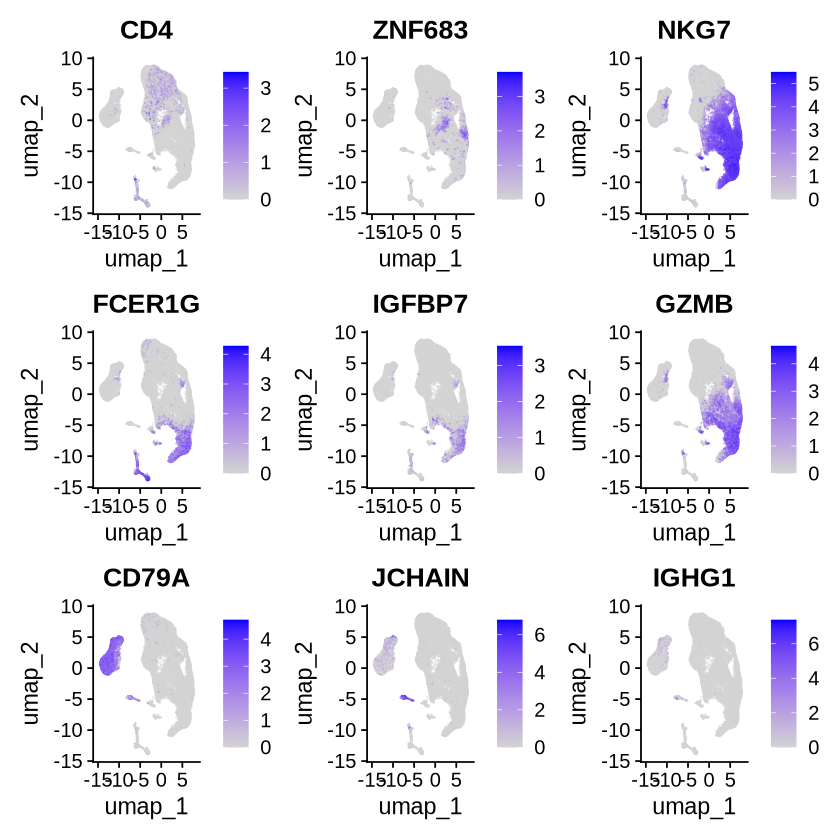

In [339]:
FeaturePlot( sc_pbmc_int2, features = c( "CD4", "ZNF683", "NKG7", "FCER1G", "IGFBP7", "GZMB", "CD79A", "JCHAIN", "IGHG1" ), 
             order = F, alpha = 0.3, reduction = "umap" )

In [ ]:
# b、cell type annotation mannually
sc_pbmc$cell_type = case_when(
  sc_pbmc$seurat_clusters %in% c( 18 ) ~ "platelets",
  sc_pbmc$seurat_clusters %in% c( 14, 17 ) ~ "monocytes",
  sc_pbmc$seurat_clusters %in% c( 3,8,15 ) ~ "B cells",
  sc_pbmc$seurat_clusters %in% c( 16 ) ~ "plasma cells",
  sc_pbmc$seurat_clusters %in% c( 1,4,5 ) ~ "CD4+ T cells",
  sc_pbmc$seurat_clusters %in% c( 0,10 ) ~ "CD8+ T cells",  
  sc_pbmc$seurat_clusters %in% c( 2,6,7,11,12,13 ) ~ "NK cells",
  sc_pbmc$seurat_clusters %in% c( 9 ) ~ "NK T cells",
  TRUE ~ "unknow"
)

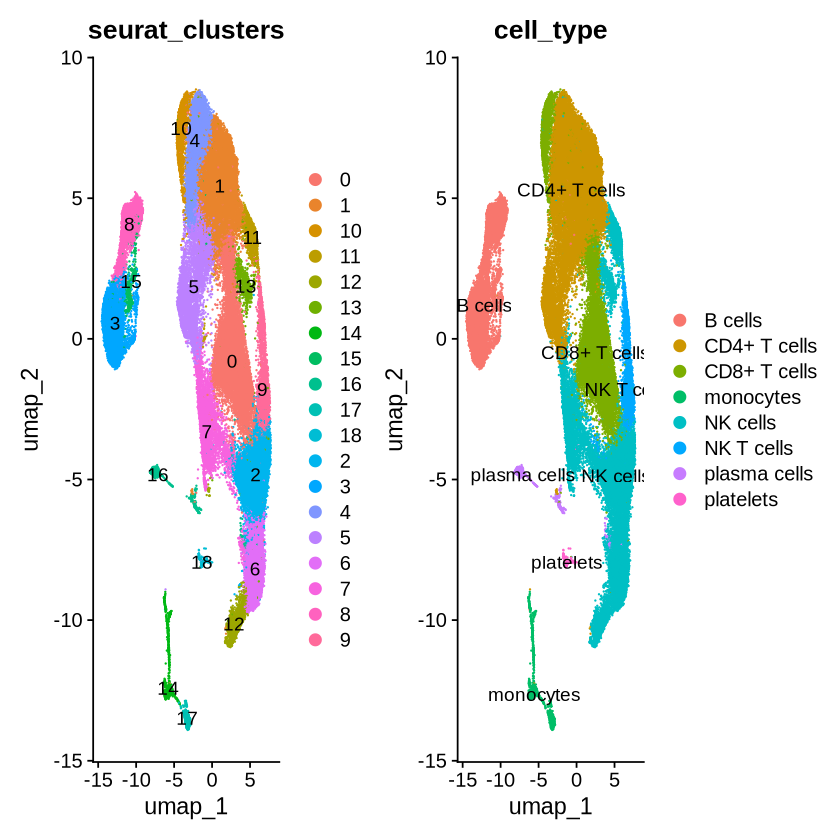

In [340]:
p1 = DimPlot( sc_pbmc, reduction = "umap", group.by = "seurat_clusters", 
              label = T, repel = F, shuffle = T )
#
p2 = DimPlot( sc_pbmc, reduction = "umap", group.by = "cell_type", 
              label = T, repel = F, shuffle = T )
#
p1 + p2

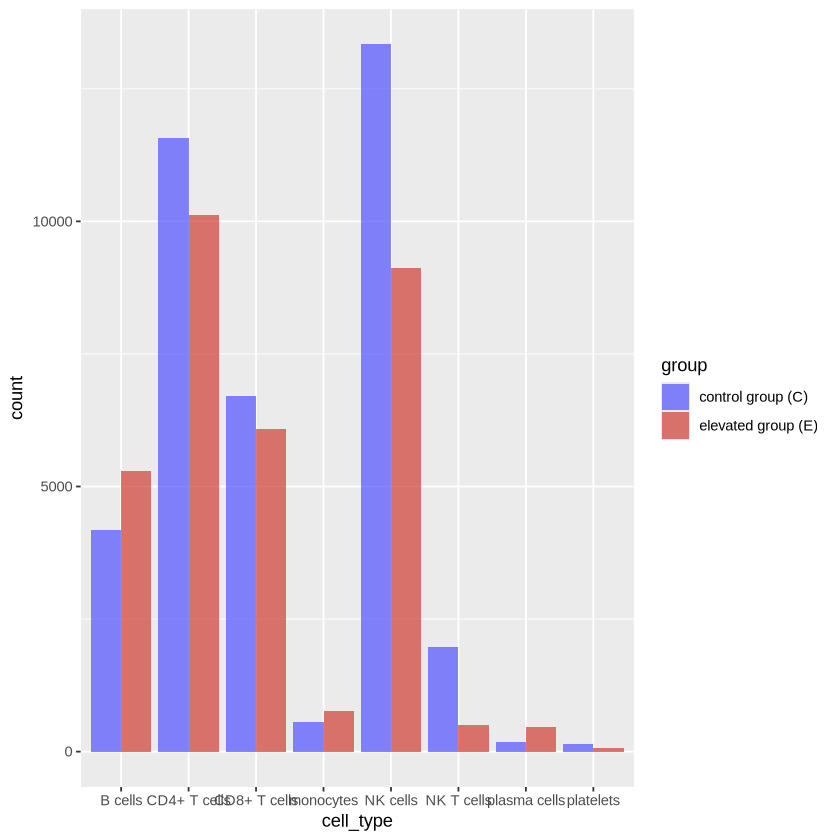

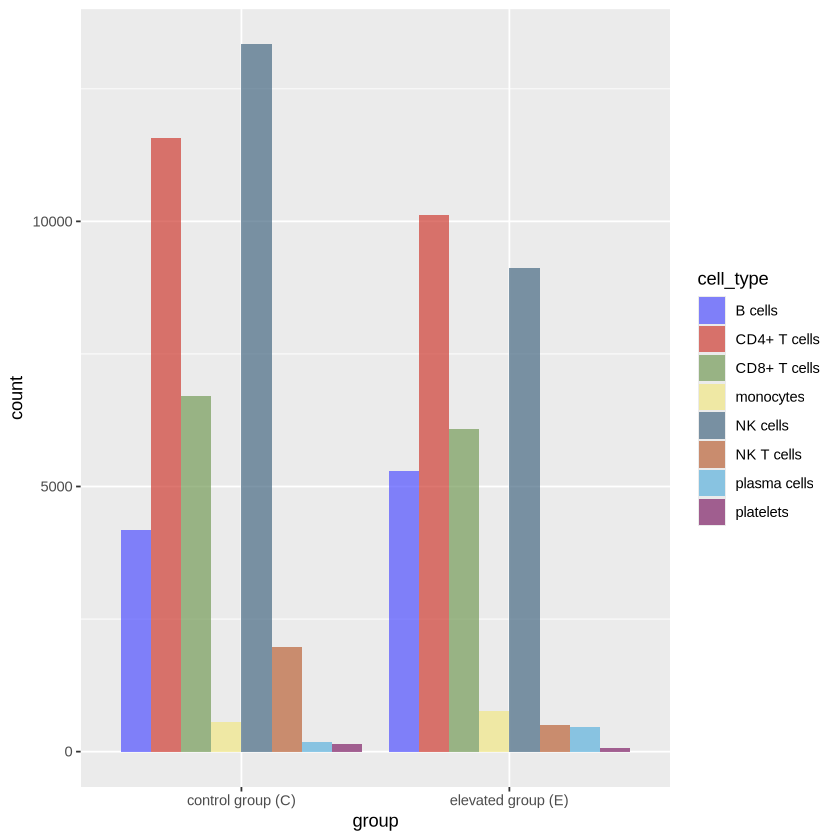

In [341]:
# cell count
ggplot( plotdata, aes( x = cell_type, fill = group ) ) +
  geom_bar( position = "dodge" ) +
  scale_fill_igv( alpha = 0.7 )

ggplot( plotdata, aes( x = group, fill = cell_type ) ) +
  geom_bar( position = "dodge" ) +
  scale_fill_igv( alpha = 0.7 )


# cell proportion
ggplot( plotdata, aes( x = orig.ident, fill = cell_type ) ) +
  geom_bar( position = "fill" ) +
  scale_fill_igv( alpha = 0.7 )

ggplot( plotdata, aes( x = group, fill = cell_type ) ) +
  geom_bar( position = "fill" ) +
  scale_fill_igv( alpha = 0.7 )

ggplot( plotdata, aes( x = individual, fill = cell_type ) ) +
  geom_bar( position = "fill" ) +
  scale_fill_igv( alpha = 0.7 )


Warning message:
“This manual palette can handle a maximum of 7 values. You have supplied 8”
Warning message:
“Removed 195 rows containing missing values or values outside the scale range
(`geom_point()`).”


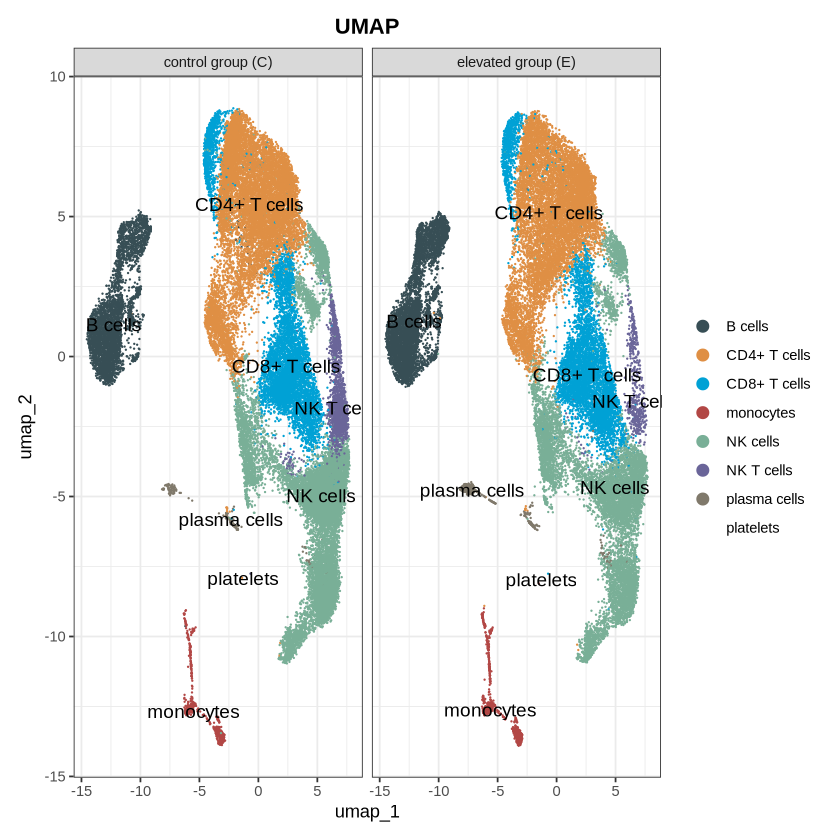

In [343]:
UMAPPlot( sc_pbmc_int2,
          label =T,
          split.by = "group",
          group.by = 'cell_type')+
  ggtitle("UMAP")+
  theme_bw( )+
  theme(
    plot.title = element_text( face = "bold", hjust = 0.5),
    plot.background = element_rect(fill = "transparent",colour = NA)
  ) +
  scale_color_jama()

In [ ]:
## DEG Analysis
Idents(sc_pbmc_int2) = "cell_type" #
#
cell.markers <- FindAllMarkers(
    object = sc_pbmc, 
    only.pos = FALSE, #
    test.use = "wilcox", #
    slot = "data", # 
    min.pct = 0.25, #
    logfc.threshold = 0.25 #
  )

In [ ]:
# b、DEG among groups
# FindMarkers - compare two groups
# FindAllMarkers - compare all groups
# ref: https://mp.weixin.qq.com/s/N5Z65CZ6B2yCFW192v8vqQ
antibody_degs = FindMarkers(
  sc_pbmc, 
  logfc.threshold = 0.5,
  # min.pct = 0.2, # 
  only.pos = FALSE,
  ident.1 = "elevated group (E)", ident.2 = "control group (C)", 
  group.by = "group" ) %>% 
  # filter( p_val_adj < 0.05 ) %>% 
  mutate( gene = rownames(.) ) #

#
vaccine_degs = FindMarkers(
  sc_pbmc, 
  logfc.threshold = 0.5,
  min.pct = 0.1,
  only.pos = FALSE,
  ident.1 = "post-vaccination", ident.2 = "pre-vaccination",  # ident 1 vs 2
  group.by = "vaccine" ) %>% 
  # filter( p_val_adj < 0.05 ) %>% 
  mutate( gene = rownames(.) )


In [ ]:
# DEG under different conditions
table(sc_pbmc_int2$cell_type)
#
sc_cd4 = subset(sc_pbmc_int2, cell_type == "CD4+ T cells" )

cell_cd4_degs <- FindMarkers( sc_cd4,  #
                          logfc.threshold = 0.5, 
                          # min.pct = 0.2,
                          ident.1 = "elevated group (E)", ident.2 = "control group (C)", # ident 1 vs 2
                          group.by = "group" ) %>% 
  mutate( gene = rownames(.) ) 

# 
cell_cd8_degs = FindMarkers( subset(sc_pbmc_int2, cell_type == "CD8+ T cells"), 
                          logfc.threshold = 0.5, #
                          # min.pct = 0.2, #
                          ident.1 = "elevated group (E)", ident.2 = "control group (C)", 
                          group.by = "group" ) %>% 
  mutate( symbol = rownames(.) )


In [ ]:
# maker among individuals
individual_C199E_deg = FindMarkers( subset(sc_pbmc_int2, individual == "C199E"), 
                                    logfc.threshold = 1,
                                    min.pct = 0.2, #
                                    ident.1 = "post-vaccination", ident.2 = "pre-vaccination", 
                                    group.by = "vaccine" ) %>% 
  mutate( symbol = rownames(.) )


# maker among individuals in CD4+ T cells
sc_cd4_post = subset( sc_pbmc_int2, cell_type == "CD4+ T cells" & vaccine == "post-vaccination" )

cell_cd4_post_degs = FindMarkers( sc_cd4_post, 
                             logfc.threshold = 0.5,
                             # min.pct = 0.2, 
                             ident.1 = "elevated group (E)", ident.2 = "control group (C)", 
                             group.by = "group" ) %>% 
  mutate( symbol = rownames(.) )


# 
cell_cd4_post_degs = cell_cd8_degs %>% 
  filter( pct.1 > 0.2 & p_val_adj < 0.01 ) %>% #
  filter( abs( avg_log2FC ) > 1 ) %>% # 
  filter( avg_log2FC > 0 ) # 

In [ ]:
## DEG visualization

library( ggrepel )
colnames( cell_cd4_degs )
table( abs(cell_cd4_degs$avg_log2FC) > 2 )

plotdt = cell_cd4_degs %>% 
  mutate( gene = ifelse( abs( avg_log2FC ) >= 2, gene, NA ) )

#
ggplot( plotdt, aes( x = avg_log2FC, y = -log10( p_val_adj ), 
                     size = pct.1,
                     color = avg_log2FC ) ) +
  geom_point( ) +
  ggtitle( label = "CD+ T cells", subtitle = "Antobody: elevated vs control" ) +
  geom_text_repel( aes( label = gene ), size = 3, color = "black" ) + # 
  theme_bw( )+
  theme(
    plot.title = element_text( face = "bold", hjust = 0.5),
    plot.background = element_rect(fill = "transparent",colour = NA)
  ) +
  scale_color_gradient2( low = "olivedrab", high = "salmon2", 
                         mid = "grey", midpoint = 0 ) +
  scale_size( range = c(1,3) )


In [ ]:
### DEG visualization
cell_cd4_degs$gene[1:10]
genexx = c( "CD8A","CD4", "IGHA1","NKG7" )

# b、bubble plot
DotPlot( sc_pbmc_int2, features = genexx ) 

#
p = DotPlot( sc_pbmc_int2, features = genexx, 
         group.by = "cell_type", 
         split.by = "group"
         ) +
  coord_flip() +
  theme(
    axis.text.x = element_text( angle = 45, hjust = 1, vjust = 1 )
  )
p
# 
p$data$colors = ifelse( grepl( "control", p$data$id), "olivedrab", "salmon2" )
p


In [ ]:
# violin plot
VlnPlot( sc_pbmc_int2, features = genexx)

VlnPlot( sc_pbmc_int2, features = genexx, 
  cols = c("olivedrab", "salmon"),
  pt.size = 0,
  group.by = "cell_type",
  split.plot = TRUE,
  split.by = "group" 
  )

#
VlnPlot( 
  sc_pbmc_int2, features = genexx, 
  group.by = "cell_type",
  stack = T,
  flip = T
) +
  scale_fill_igv() #


# featureplot
FeaturePlot( 
  sc_pbmc_int2,
  features = genexx,
  reduction = "umap", #
  pt.size = 0.1, #
  alpha = 0.5, # 
  cols = c("grey", "brown"),
  ncol = 2
  )

#
FeaturePlot( 
  sc_pbmc_int2,
  features = genexx,
  reduction = "umap", 
  order = T, # if T, the features will be ordered by the average expression
  cols = c("grey", "brown"),
  ncol = 2
)

#
FeaturePlot( 
  sc_pbmc_int2,
  features = "CD8A",
  reduction = "umap", 
  cols = c("olivedrab", "orangered"),
  split.by = "group", 
)